here


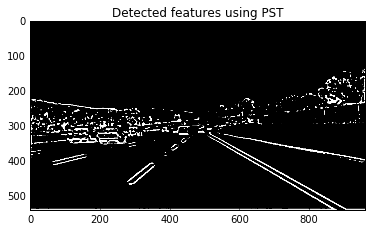

here


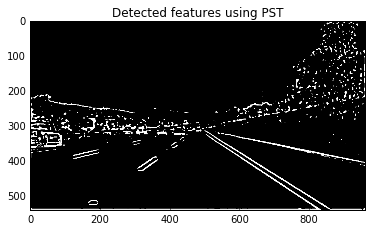

here


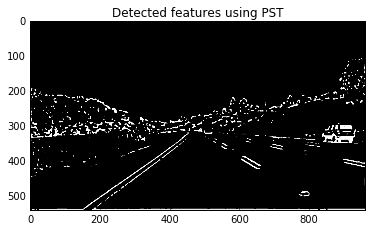

here


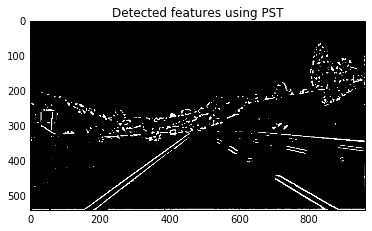

here


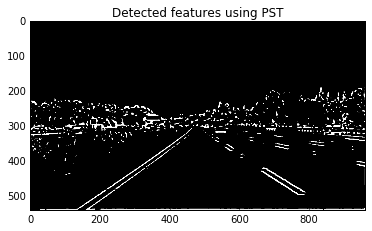

here


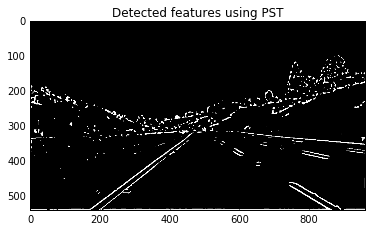

In [1]:
# This is experimental code for research purpose
# Ref: https://github.com/JalaliLabUCLA/Image-feature-detection-using-Phase-Stretch-Transform
import math
import cv2

import skimage
from skimage import data
from skimage import io
from skimage.color import rgb2gray

from PIL import Image
from matplotlib import pylab as plt

import numpy as np
import glob

def pst(image, lpf=0.1, phase_strength=0.48, warp_strength=13, thresh_min=-1, thresh_max=0.0019, morph_flag=False):
    # port of https://github.com/JalaliLabUCLA/Image-feature-detection-using-Phase-Stretch-Transform
    # restrictions on usage apply, consult the original source!
    import numpy
    from numpy.fft import fft2, ifft2, fftshift

    def cart2pol(x, y):
        return numpy.arctan2(y, x), numpy.hypot(x, y)

    image = image.astype(numpy.float64)

    L = 0.5

    x = numpy.linspace(-L, L, image.shape[1])
    y = numpy.linspace(-L, L, image.shape[0])

    X, Y = numpy.meshgrid(x, y)

    THETA, RHO = cart2pol(X, Y)

    X_step = x[1]-x[0]
    Y_step = y[1]-y[0]

    fx = numpy.linspace(-L/X_step, L/X_step, len(x))
    fy = numpy.linspace(-L/Y_step, L/Y_step, len(y))

    fx_step = fx[1]-fx[0]
    fy_step = fy[1]-fy[0]

    FX, FY = numpy.meshgrid(fx_step, fy_step)

    FTHETA, FRHO = cart2pol(FX, FY)

    # lowpass

    sigma = (lpf ** 2) / numpy.log(2)

    image_f = fft2(image)   
    image_f = image_f * fftshift(numpy.exp(-(RHO / numpy.sqrt(sigma))**2))
    image_filtered = numpy.real(ifft2(image_f))

    # PST kernel construction

    rws = RHO*warp_strength
    pst_kernel = rws * numpy.arctan(rws) - 0.5*numpy.log(1+(rws**2))
    pst_kernel /= pst_kernel.max()
    pst_kernel *= phase_strength

    # application of the kernel, and phase calculation

    image_processed = ifft2(fft2(image_filtered) * fftshift(numpy.exp(-1j * pst_kernel)))

    result = numpy.angle(image_processed)

    if morph_flag == False:
        return result
    else:
        binary = numpy.zeros_like(image, dtype=bool)

        binary[result > thresh_max] = 1
        binary[result < thresh_min] = 1    
        binary[image < image.max() / 20] = 0

        # the matlab version does post-processing (cleaning) here!

        return binary

if __name__ == '__main__':
    images = glob.glob('test_images/*.jpg')
    
    for image_path in images: 
        img = io.imread(image_path)
        grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        morph_flag=True
        edge = pst(grey, morph_flag=True)
        if morph_flag == 1:
            final = edge/np.max(edge)*3
            print("here")
            plt.imshow(edge, cmap='Greys_r')
        else:
            plt.imshow(edge, 'gray')
            pass
        plt.title('Detected features using PST')
        plt.show()

